In [72]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.mlab import psd

### NACA 4 digit airfoil generator

In [73]:
def naca_airfoil(code, num_points, zero_thick_te=False, uniform=False):
    """Return a NACA 4-digit series airfoil"""
    # extract parameters from 4-digit code
    code_str = "%04d" % int(code)
    if len(code_str) != 4:
        raise ValueError("NACA designation is more than 4 digits")
    max_camber = 0.01 * int(code_str[0])
    p = 0.1 * int(code_str[1])  # location of max camber
    thickness = 0.01 * int(code_str[2:])
    if uniform:
        x = np.linspace(0, 1, num_points)
    else:
        # closer spacing near leading edge
        theta = np.linspace(0, 0.5 * np.pi, num_points)
        x = 1 - np.cos(theta)

    # thickness
    coefs = [-0.1015, 0.2843, -0.3516, -0.1260, 0, 0.2969]
    if zero_thick_te:
        coefs[0] = -0.1036
    y_thick = 5 * thickness * (np.polyval(coefs[:5], x) +
                               coefs[5] * np.sqrt(x))

    # camber
    front = np.where(x <= p)
    back = np.where(x > p)
    y_camber = np.zeros_like(x)
    if p:
        y_camber[front] = max_camber * x[front] / p**2 * (2 * p - x[front])
        y_camber[back] = max_camber * ((1. - x[back])/(1. - p)**2 *
                                       (1 + x[back] - 2 * p))
    x = np.hstack([x[-1:0:-1], x])
    y = np.hstack([y_camber[-1:0:-1] + y_thick[-1:0:-1],
                   y_camber - y_thick])
    return (np.array([x, y]).T)

### Declaring a variable to store cooridnates of airfoil

In [74]:
q = naca_airfoil(0012, 101)

### Collacation point (obervations point on the airfoil where the vortex influence will be captured)

In [75]:
q_mid = (q[1:] + q[:-1])/2

### Defining the computational domain where the vortices are distributed

In [76]:
length = 100. #nondimensional length of window
height = 0.1 #window height
N = 10000 #number of vortices
gammas = 1. #vortex strength RMS (normal distribution)
rscale = 0.1 #vortex size scale (rayleigh distribution parameter)
t0 = -10.#start time for observation of convection
t1 = 10.#end time
ts = 0.01 # time step
v0 = 5 #convection speed

### Set random distribution for vortex location, size and strength
origin at window center

In [77]:
vortx = np.random.uniform(low=-length/2,high=length/2,size=N)
vorty = np.random.uniform(low=-height/2,high=height/2,size=N)
vortX = np.vstack((vortx,vorty))
gamma = np.random.normal(scale=gammas,size=N)
rho = np.random.rayleigh(scale=rscale,size=N)

In [78]:
nn = 20 # number of injection lines
#vortx = (np.random.uniform(low=-length/2,high=length/2,size=N/nn))[np.newaxis].T
#vortx = np.hstack(([vortx]*nn))
#vortx[:,0] = np.random.uniform(low=-length/2,high=length/2,size=(N/nn,20))
vortx = np.random.uniform(low=-length/2,high=length/2,size=(N/nn,nn))
vorty = np.ones_like(vortx)
K = np.arange(-0.1,0.1,0.01)
vorty = K * vorty
vortx = vortx.T
vorty = vorty.T
vortx = vortx.flatten()
vorty = vorty.flatten()
gamma = np.random.normal(scale=gammas,size=N)
rho = np.random.rayleigh(scale=rscale,size=N)

### Solver/time-stepper

In [79]:
t = np.arange(t0,t1,ts) # number of time-steps
# print t
print len(t)

2000


In [80]:
A = [] # empty array to store cl value after each iteration
for i in range(len(t)):
    print "this is the iteration {} / {}".format(i, len(t))
    i = i * ts * v0
    obsx = q_mid[:,0] + (length/2)
    obsx = (obsx - i )
    obsy = q_mid[:,1]
    obsX = np.vstack((obsx,obsy))
    dist = obsX[:,:,np.newaxis]-vortX[:,np.newaxis,:] # dim 2 x timesteps x N
    r = np.sqrt((dist*dist).sum(0)) # dim timesteps x N
    utheta = 16 * gamma * (rho**(-3)) * np.exp(-8*(rho**(-4)) * r**2) * (3-(16 * (rho**(-4)) * r**2)) * r   # Mexican-hat shape
    uind = utheta * dist[::-1] # dim 2 x timesteps x N
    uind[0] *= -1 # change sign for ux (to get correct rotation)
    ux = uind[0].T
    utot = uind.sum(2) # dim 2 x timesteps
    q_newx = q[:,0] + (length/2)
    q_newx = q_newx - i
    q_newy = q[:,1]
    q = np.array([q_newx, q_newy]).T
    dq = np.diff(q, axis=0)
    numpanels = dq.shape[0]
    lengths = np.linalg.norm(dq, axis=1) 
    normals = np.transpose(np.array([dq[:,1], -dq[:,0]]) / lengths)
    tangents = -np.transpose(np.array([dq[:,0], dq[:,1]]) / lengths)
    utot_tangent = utot.T * tangents
    utot_tangent_magnitude = pow((pow(utot_tangent[:,0],2) + pow(utot_tangent[:,1],2)), 0.5)
    p_ref =0
    p = p_ref + (0.5 * 1.225 * (v0**2 - ux**2))
    cp = (1 - ((utot_tangent_magnitude**2)/v0**2))
#     cp = (1 - ((ux**2)/v0**2))
    cp = cp * normals[:,1]
    cl = cp.sum(0)
    A.append(cl)

this is the iteration 0 / 2000
this is the iteration 1 / 2000
this is the iteration 2 / 2000
this is the iteration 3 / 2000
this is the iteration 4 / 2000
this is the iteration 5 / 2000
this is the iteration 6 / 2000
this is the iteration 7 / 2000
this is the iteration 8 / 2000
this is the iteration 9 / 2000
this is the iteration 10 / 2000
this is the iteration 11 / 2000
this is the iteration 12 / 2000
this is the iteration 13 / 2000
this is the iteration 14 / 2000
this is the iteration 15 / 2000
this is the iteration 16 / 2000
this is the iteration 17 / 2000
this is the iteration 18 / 2000
this is the iteration 19 / 2000
this is the iteration 20 / 2000
this is the iteration 21 / 2000
this is the iteration 22 / 2000
this is the iteration 23 / 2000
this is the iteration 24 / 2000
this is the iteration 25 / 2000
this is the iteration 26 / 2000
this is the iteration 27 / 2000
this is the iteration 28 / 2000
this is the iteration 29 / 2000
this is the iteration 30 / 2000
this is the iterat

this is the iteration 252 / 2000
this is the iteration 253 / 2000
this is the iteration 254 / 2000
this is the iteration 255 / 2000
this is the iteration 256 / 2000
this is the iteration 257 / 2000
this is the iteration 258 / 2000
this is the iteration 259 / 2000
this is the iteration 260 / 2000
this is the iteration 261 / 2000
this is the iteration 262 / 2000
this is the iteration 263 / 2000
this is the iteration 264 / 2000
this is the iteration 265 / 2000
this is the iteration 266 / 2000
this is the iteration 267 / 2000
this is the iteration 268 / 2000
this is the iteration 269 / 2000
this is the iteration 270 / 2000
this is the iteration 271 / 2000
this is the iteration 272 / 2000
this is the iteration 273 / 2000
this is the iteration 274 / 2000
this is the iteration 275 / 2000
this is the iteration 276 / 2000
this is the iteration 277 / 2000
this is the iteration 278 / 2000
this is the iteration 279 / 2000
this is the iteration 280 / 2000
this is the iteration 281 / 2000
this is th

this is the iteration 501 / 2000
this is the iteration 502 / 2000
this is the iteration 503 / 2000
this is the iteration 504 / 2000
this is the iteration 505 / 2000
this is the iteration 506 / 2000
this is the iteration 507 / 2000
this is the iteration 508 / 2000
this is the iteration 509 / 2000
this is the iteration 510 / 2000
this is the iteration 511 / 2000
this is the iteration 512 / 2000
this is the iteration 513 / 2000
this is the iteration 514 / 2000
this is the iteration 515 / 2000
this is the iteration 516 / 2000
this is the iteration 517 / 2000
this is the iteration 518 / 2000
this is the iteration 519 / 2000
this is the iteration 520 / 2000
this is the iteration 521 / 2000
this is the iteration 522 / 2000
this is the iteration 523 / 2000
this is the iteration 524 / 2000
this is the iteration 525 / 2000
this is the iteration 526 / 2000
this is the iteration 527 / 2000
this is the iteration 528 / 2000
this is the iteration 529 / 2000
this is the iteration 530 / 2000
this is th

this is the iteration 750 / 2000
this is the iteration 751 / 2000
this is the iteration 752 / 2000
this is the iteration 753 / 2000
this is the iteration 754 / 2000
this is the iteration 755 / 2000
this is the iteration 756 / 2000
this is the iteration 757 / 2000
this is the iteration 758 / 2000
this is the iteration 759 / 2000
this is the iteration 760 / 2000
this is the iteration 761 / 2000
this is the iteration 762 / 2000
this is the iteration 763 / 2000
this is the iteration 764 / 2000
this is the iteration 765 / 2000
this is the iteration 766 / 2000
this is the iteration 767 / 2000
this is the iteration 768 / 2000
this is the iteration 769 / 2000
this is the iteration 770 / 2000
this is the iteration 771 / 2000
this is the iteration 772 / 2000
this is the iteration 773 / 2000
this is the iteration 774 / 2000
this is the iteration 775 / 2000
this is the iteration 776 / 2000
this is the iteration 777 / 2000
this is the iteration 778 / 2000
this is the iteration 779 / 2000
this is th

this is the iteration 999 / 2000
this is the iteration 1000 / 2000
this is the iteration 1001 / 2000
this is the iteration 1002 / 2000
this is the iteration 1003 / 2000
this is the iteration 1004 / 2000
this is the iteration 1005 / 2000
this is the iteration 1006 / 2000
this is the iteration 1007 / 2000
this is the iteration 1008 / 2000
this is the iteration 1009 / 2000
this is the iteration 1010 / 2000
this is the iteration 1011 / 2000
this is the iteration 1012 / 2000
this is the iteration 1013 / 2000
this is the iteration 1014 / 2000
this is the iteration 1015 / 2000
this is the iteration 1016 / 2000
this is the iteration 1017 / 2000
this is the iteration 1018 / 2000
this is the iteration 1019 / 2000
this is the iteration 1020 / 2000
this is the iteration 1021 / 2000
this is the iteration 1022 / 2000
this is the iteration 1023 / 2000
this is the iteration 1024 / 2000
this is the iteration 1025 / 2000
this is the iteration 1026 / 2000
this is the iteration 1027 / 2000
this is the ite

this is the iteration 1240 / 2000
this is the iteration 1241 / 2000
this is the iteration 1242 / 2000
this is the iteration 1243 / 2000
this is the iteration 1244 / 2000
this is the iteration 1245 / 2000
this is the iteration 1246 / 2000
this is the iteration 1247 / 2000
this is the iteration 1248 / 2000
this is the iteration 1249 / 2000
this is the iteration 1250 / 2000
this is the iteration 1251 / 2000
this is the iteration 1252 / 2000
this is the iteration 1253 / 2000
this is the iteration 1254 / 2000
this is the iteration 1255 / 2000
this is the iteration 1256 / 2000
this is the iteration 1257 / 2000
this is the iteration 1258 / 2000
this is the iteration 1259 / 2000
this is the iteration 1260 / 2000
this is the iteration 1261 / 2000
this is the iteration 1262 / 2000
this is the iteration 1263 / 2000
this is the iteration 1264 / 2000
this is the iteration 1265 / 2000
this is the iteration 1266 / 2000
this is the iteration 1267 / 2000
this is the iteration 1268 / 2000
this is the it

this is the iteration 1481 / 2000
this is the iteration 1482 / 2000
this is the iteration 1483 / 2000
this is the iteration 1484 / 2000
this is the iteration 1485 / 2000
this is the iteration 1486 / 2000
this is the iteration 1487 / 2000
this is the iteration 1488 / 2000
this is the iteration 1489 / 2000
this is the iteration 1490 / 2000
this is the iteration 1491 / 2000
this is the iteration 1492 / 2000
this is the iteration 1493 / 2000
this is the iteration 1494 / 2000
this is the iteration 1495 / 2000
this is the iteration 1496 / 2000
this is the iteration 1497 / 2000
this is the iteration 1498 / 2000
this is the iteration 1499 / 2000
this is the iteration 1500 / 2000
this is the iteration 1501 / 2000
this is the iteration 1502 / 2000
this is the iteration 1503 / 2000
this is the iteration 1504 / 2000
this is the iteration 1505 / 2000
this is the iteration 1506 / 2000
this is the iteration 1507 / 2000
this is the iteration 1508 / 2000
this is the iteration 1509 / 2000
this is the it

this is the iteration 1722 / 2000
this is the iteration 1723 / 2000
this is the iteration 1724 / 2000
this is the iteration 1725 / 2000
this is the iteration 1726 / 2000
this is the iteration 1727 / 2000
this is the iteration 1728 / 2000
this is the iteration 1729 / 2000
this is the iteration 1730 / 2000
this is the iteration 1731 / 2000
this is the iteration 1732 / 2000
this is the iteration 1733 / 2000
this is the iteration 1734 / 2000
this is the iteration 1735 / 2000
this is the iteration 1736 / 2000
this is the iteration 1737 / 2000
this is the iteration 1738 / 2000
this is the iteration 1739 / 2000
this is the iteration 1740 / 2000
this is the iteration 1741 / 2000
this is the iteration 1742 / 2000
this is the iteration 1743 / 2000
this is the iteration 1744 / 2000
this is the iteration 1745 / 2000
this is the iteration 1746 / 2000
this is the iteration 1747 / 2000
this is the iteration 1748 / 2000
this is the iteration 1749 / 2000
this is the iteration 1750 / 2000
this is the it

this is the iteration 1963 / 2000
this is the iteration 1964 / 2000
this is the iteration 1965 / 2000
this is the iteration 1966 / 2000
this is the iteration 1967 / 2000
this is the iteration 1968 / 2000
this is the iteration 1969 / 2000
this is the iteration 1970 / 2000
this is the iteration 1971 / 2000
this is the iteration 1972 / 2000
this is the iteration 1973 / 2000
this is the iteration 1974 / 2000
this is the iteration 1975 / 2000
this is the iteration 1976 / 2000
this is the iteration 1977 / 2000
this is the iteration 1978 / 2000
this is the iteration 1979 / 2000
this is the iteration 1980 / 2000
this is the iteration 1981 / 2000
this is the iteration 1982 / 2000
this is the iteration 1983 / 2000
this is the iteration 1984 / 2000
this is the iteration 1985 / 2000
this is the iteration 1986 / 2000
this is the iteration 1987 / 2000
this is the iteration 1988 / 2000
this is the iteration 1989 / 2000
this is the iteration 1990 / 2000
this is the iteration 1991 / 2000
this is the it

#### Unsteady lift

In [81]:
print p
dp_ = np.diff(p, axis=0)
dp = dp_ * lengths
print dp
np.savetxt('dp.csv', np.column_stack((dp)), fmt='%0.5f', delimiter=',')
dt = ts

[[15.3125 15.3125 15.3125 ... 15.3125 15.3125 15.3125]
 [15.3125 15.3125 15.3125 ... 15.3125 15.3125 15.3125]
 [15.3125 15.3125 15.3125 ... 15.3125 15.3125 15.3125]
 ...
 [15.3125 15.3125 15.3125 ... 15.3125 15.3125 15.3125]
 [15.3125 15.3125 15.3125 ... 15.3125 15.3125 15.3125]
 [15.3125 15.3125 15.3125 ... 15.3125 15.3125 15.3125]]
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]


<function matplotlib.pyplot.show>

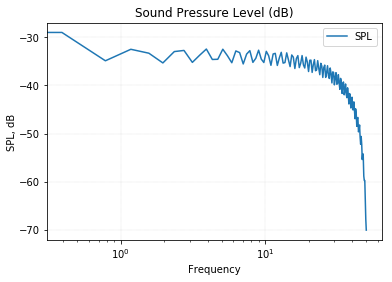

In [82]:
obs_x = 0
# obsx = (obsx - i )
obs_y = 1
obs_X = np.vstack((obs_x,obs_y))
# print obsX
vort_X = np.vstack((q_mid[:,0],q_mid[:,1]))
#print vort_X
dist_ = obs_X[:,:,np.newaxis]-vort_X[:,np.newaxis,:] # dim 2 x timesteps x N
r_ = np.sqrt((dist_*dist_).sum(0)) # dim timesteps x N
#print r_

tau = dt - (r_/340)

p_acoustic = (((obs_X*(normals.T)).sum(0))/(4*np.pi*340)) * ((dp/(tau*(r_**2)))[np.newaxis])
#var_1 = (dp/(tau*(r_**2)))[np.newaxis]
p_acoustic_1 = p_acoustic[0,:,:].sum(axis=1)

H_NC = ((np.abs(p_acoustic_1))/(2.e-5))**2
# print H
(val_NC, freq_NC) = psd(H_NC,Fs=1/dt,detrend='mean')
SPL = 10*np.log10(val_NC)
#savetxt('SPL.csv', np.column_stack((freq,SPL)), fmt='%0.5f', delimiter=',')
# print SPL
#plt.savefig('SPL.pdf')
#print freq
plt.semilogx(freq_NC,10*np.log10(val_NC),linestyle='-',alpha=1.0,label='SPL')
plt.title('Sound Pressure Level (dB)')
plt.xlabel('Frequency')
plt.ylabel('SPL, dB',labelpad=1.5)
plt.grid(color='0.5',linestyle=':',linewidth=0.2)
plt.legend()
# plt.savefig('SPL_chack.pdf')
plt.show

In [83]:
A = np.array(A)

### Curle's analogy to obtain p' at a distance of 1 unit at theta=90 deg

In [84]:
def Curles_loadingNoise(y_int,c_sound,r_dist,L,dt,Velo):
#     p_acoustic = (((y_int*L)/(4*np.pi*dt*c_sound*(r_dist**2)))*(0.5*1.225*pow(Velo,2)))
    p_acoustic = (((y_int*L)/(4*np.pi*dt*c_sound*(r_dist**2))))

    return p_acoustic

noise = Curles_loadingNoise(1,343,1,np.abs(A),ts,v0)
H = ((noise)/(2.e-5))**2

### Plot unsteady lift on the airfoil and the SPL in far-field 

ValueError: only 1-dimensional arrays can be used

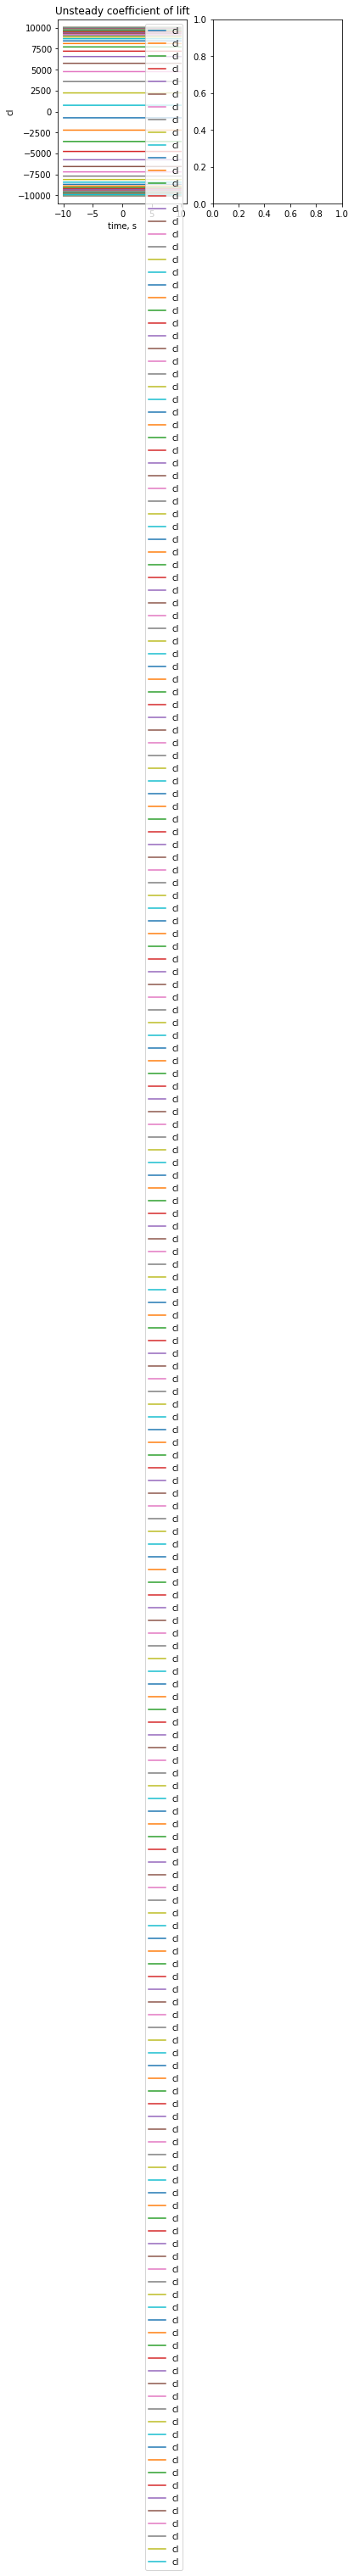

In [85]:
plt.figure(1)
plt.subplot(1,2,1)
plt.plot(t,A,label='cl')
plt.title('Unsteady coefficient of lift')
plt.xlabel('time, s')
plt.ylabel('cl')
plt.legend()
plt.subplot(1,2,2)
(val, freq) = psd(H,Fs=1/ts,detrend='mean')
plt.semilogx(freq,10*np.log10(val),label='SPL')
plt.title('Sound Pressure Level (dB)')
plt.xlabel('Frequency')
plt.ylabel('SPL, dB')
plt.legend()
plt.savefig('cl_SPL.pdf')
plt.show